In [47]:
# Standard Library
import itertools
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

# Numerical Analysis
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statsmodels
import statsmodels.api as sm
from statsmodels.api import tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# scikit-learn
from sklearn.model_selection import ParameterGrid, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly

# XGBoost
import xgboost as xgb
from xgboost import plot_importance, plot_tree

# Matplotlib Configuration
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams.update({
    # Figure Aesthetics
    'figure.figsize': (8, 5),
    'figure.facecolor': 'white',
    
    # Axes and Grid
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.linewidth': 0.8,
    'axes.grid': True,
    'axes.grid.axis': 'y',
    'axes.grid.which': 'major',
    'grid.color': 'lightgray',
    'grid.linestyle': '-',
    'grid.linewidth': 0.5,

    # Spines (Borders)
    'axes.spines.top': False,
    'axes.spines.right': False,
    
    # Ticks and Tick Labels
    'xtick.bottom': True,
    'xtick.major.size': 3,
    'xtick.minor.size': 0,
    'ytick.left': True,
    'ytick.major.size': 3,
    'ytick.minor.size': 0,

    # Fonts and Text
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica', 'Arial', 'DejaVu Sans', 'Lucida Grande', 'Verdana'],
    'font.size': 10,
    'axes.labelsize': 10,
    'axes.titlesize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,

    # Lines and Markers
    'lines.linewidth': 1.5,
    'lines.markersize': 5,

    # Colors
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'axes.titlecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
})

# Utils (commented out as not being used, but can be uncommented as needed)
# from ts_utils import load_and_clean_air_traffic, \
#     lag_plots, \
#     decompose_series, \
#     perform_adf_test, \
#     perform_kpss_test


# Modeling

## Prophet

**Notes**
- Using Facebook Prophet to help capture trends, seasons and any other events in our traffic data time series prediction

In [49]:
# Load the CSV file
# modeling_data = pd.read_csv("../data/processed_data_monthly.csv")
modeling_data = pd.read_csv("../data/scaled_processed_data_monthly.csv")
print(modeling_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 285 non-null    int64  
 1   timestamp                  285 non-null    object 
 2   all_motor_vehicles         285 non-null    float64
 3   all_motor_vehicles_scaled  285 non-null    float64
 4   traffic_ma_7               279 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 11.3+ KB
None


In [51]:
# Convert the 'timestamp' column to datetime format
modeling_data['timestamp'] = pd.to_datetime(modeling_data['timestamp'])

In [52]:

modeling_data.head()

,Unnamed: 0,timestamp,all_motor_vehicles,all_motor_vehicles_scaled,traffic_ma_7
0,0,2000-03-01,4079983.0,0.143257,NaN
1,1,2000-04-01,11856901.0,0.416770,NaN
2,2,2000-05-01,9222997.0,0.324136,NaN
3,3,2000-06-01,8759275.0,0.307827,NaN
4,4,2000-07-01,10122191.0,0.355760,NaN


In [53]:
modeling_data.columns

Index(['Unnamed: 0', 'timestamp', 'all_motor_vehicles',
       'all_motor_vehicles_scaled', 'traffic_ma_7'],
      dtype='object')

In [57]:
modeling_data.shape

(285, 5)

In [58]:
# Determine target variable and feature
prophet_data = modeling_data[['timestamp', 'all_motor_vehicles']].rename(columns={'timestamp': 'ds', 'all_motor_vehicles': 'y'})

In [59]:
prophet_data.shape

(285, 2)

In [60]:
prophet_data.head()

,ds,y
0,2000-03-01,4079983.0
1,2000-04-01,11856901.0
2,2000-05-01,9222997.0
3,2000-06-01,8759275.0
4,2000-07-01,10122191.0


In [61]:
prophet_data['y'].head(10)

0     4079983.0
1    11856901.0
2     9222997.0
3     8759275.0
4    10122191.0
5     9359520.0
6     8239066.0
7     9456167.0
8     6891120.0
9     7120824.0
Name: y, dtype: float64

In [62]:
prophet_data['ds'].head(10)

0   2000-03-01
1   2000-04-01
2   2000-05-01
3   2000-06-01
4   2000-07-01
5   2000-08-01
6   2000-09-01
7   2000-10-01
8   2000-11-01
9   2000-12-01
Name: ds, dtype: datetime64[ns]

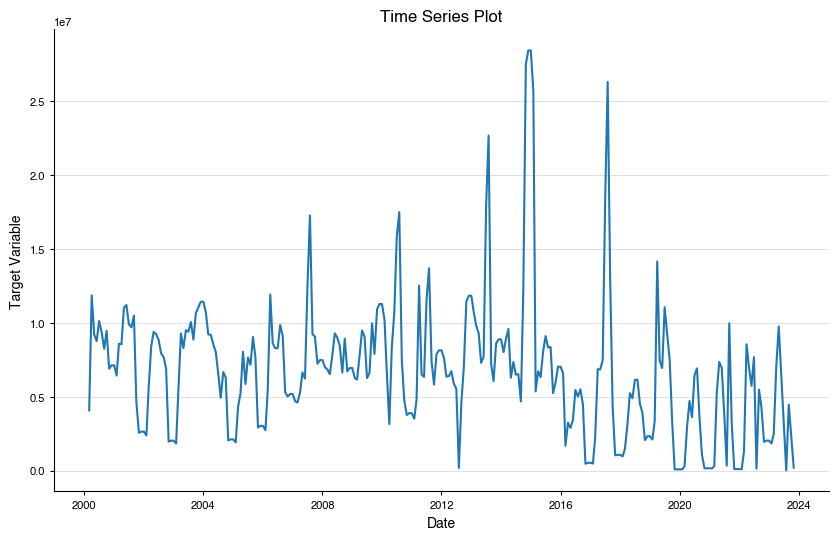

In [63]:
# Visualize the time series
plt.figure(figsize=(10, 6))
plt.plot(prophet_data['ds'], prophet_data['y'])
plt.xlabel('Date')
plt.ylabel('Target Variable')
plt.title('Time Series Plot')
plt.show()

**Observation**
- The data shows significant fluctuations in the "Target Variable" over time, with numerous peaks and troughs indicating dynamic and frequent changes in the target variable within short time intervals.
- Moreover, there are noticeable seasonal or cyclical patterns, suggesting that vehicle counts follow a regular seasonal pattern.

### Train/Test Split

In [64]:
prophet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      285 non-null    datetime64[ns]
 1   y       285 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.6 KB


In [65]:
ptrain = prophet_data.loc[prophet_data.ds <= "2020-12-01", :]  # Training set up to Dec 2020
ptest = prophet_data.loc[prophet_data.ds > "2020-12-01", :]    # Test set after Dec 2020

In [66]:
print(f"Length of ptrain: {len(ptrain)}")
print(f"Length of ptest: {len(ptest)}")

Length of ptrain: 250
Length of ptest: 35


In [67]:
ptrain.head()

,ds,y
0,2000-03-01,4079983.0
1,2000-04-01,11856901.0
2,2000-05-01,9222997.0
3,2000-06-01,8759275.0
4,2000-07-01,10122191.0


In [68]:
ptrain.ds.min()

Timestamp('2000-03-01 00:00:00')

In [69]:
ptest.head()

,ds,y
250,2021-01-01,153264.0
251,2021-02-01,138432.0
252,2021-03-01,293061.0
253,2021-04-01,5293743.0
254,2021-05-01,7347240.0


In [70]:
ptest.shape

(35, 2)

### Naive Model

In [71]:
pred_df = ptest.copy()

In [72]:
pred_df.head()

,ds,y
250,2021-01-01,153264.0
251,2021-02-01,138432.0
252,2021-03-01,293061.0
253,2021-04-01,5293743.0
254,2021-05-01,7347240.0


In [73]:
pred_df.columns

Index(['ds', 'y'], dtype='object')

In [74]:
pred_df.shape

(35, 2)

In [75]:
ptrain_naive = prophet_data.loc[prophet_data.ds <= "2020-12-01", :]  # Training set up to Dec 2020
ptest_naive = prophet_data.loc[prophet_data.ds > "2020-12-01", :]    # Test set after Dec 2020

In [77]:
print(ptest_naive.columns)

Index(['ds', 'y'], dtype='object')


In [78]:

ptest_naive['naive_forecast'] = ptest_naive['y'].shift(1)

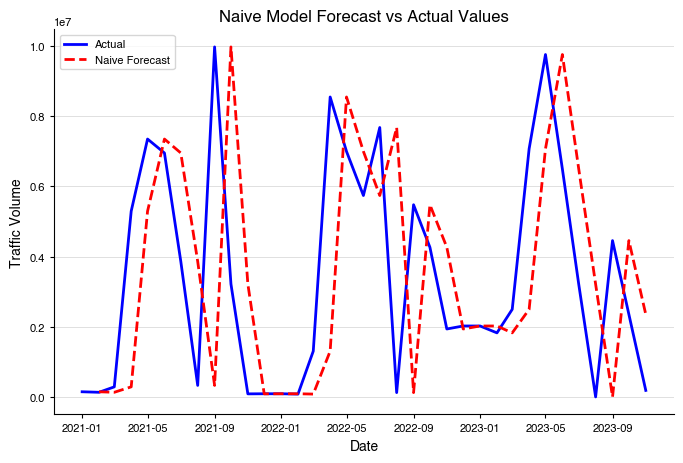

In [79]:
import matplotlib.pyplot as plt

# Plot the actual values
plt.plot(ptest_naive['ds'], ptest_naive['y'], label='Actual', color='blue', linewidth=2)

# Plot the naive forecast
plt.plot(ptest_naive['ds'], ptest_naive['naive_forecast'], label='Naive Forecast', color='red', linestyle='--', linewidth=2)
plt.title('Naive Model Forecast vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

In [84]:
import numpy as np

# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero by filtering out 0 values in the true data
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

# Calculate MAPE between actual values and the naive forecast
mape = mean_absolute_percentage_error(ptest_naive['y'][1:], ptest_naive['naive_forecast'][1:])
print(f'MAPE: {mape:.2f}%')


MAPE: 1789.09%


In [82]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

# Calculate SMAPE
smape = symmetric_mean_absolute_percentage_error(ptest_naive['y'][1:], ptest_naive['naive_forecast'][1:])
print(f'SMAPE: {smape:.2f}%')

SMAPE: 82.37%


**Notes**
- Using SMAPE as the metric for evaluation instead of MAPE because of the small values in the data (most values are less than 1 - close to zero)
- SMAPE (Symmetric Mean Absolute Percentage Error)
    - SMAPE is a variation of MAPE that addresses the issue of small values by dividing by the average of actual and forecasted values

### Prophet Prediction

In [126]:
# Build and fit the model on the training data
from prophet import Prophet

# Initialize the Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False) 

# Add country holidays
model.add_country_holidays(country_name='UK')  # For adding standard UK holidays

model.fit(ptrain) # Fit the model on the training set

23:53:30 - cmdstanpy - INFO - Chain [1] start processing
23:53:30 - cmdstanpy - INFO - Chain [1] done processing


In [127]:
# Forecasting into the future
future = model.make_future_dataframe(periods=len(ptest), freq='MS')  # Future DataFrame to forecast test period

In [128]:
ptest.head()

,ds,y,mean_forecast,naive_forecast,seasonal_naive_forecast
250,2021-01-01,153264.0,7224024.432,153264.0,79608.0
251,2021-02-01,138432.0,7224024.432,153264.0,74472.0
252,2021-03-01,293061.0,7224024.432,153264.0,276847.0
253,2021-04-01,5293743.0,7224024.432,153264.0,2954148.0
254,2021-05-01,7347240.0,7224024.432,153264.0,4705494.0


In [129]:
future.head()

,ds
0,2000-03-01
1,2000-04-01
2,2000-05-01
3,2000-06-01
4,2000-07-01


### Make Predictions

In [130]:
forecast = model.predict(future) 

In [131]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Boxing Day,Boxing Day_lower,Boxing Day_upper,Boxing Day (observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-03-01,7.163418e+06,-1.157111e+06,9.224724e+06,7.163418e+06,7.163418e+06,0.0,0.0,0.0,0.0,...,-1.275438e+06,-1.275438e+06,-1.275438e+06,-1.834859e+06,-1.834859e+06,-1.834859e+06,0.0,0.0,0.0,4.053121e+06
1,2000-04-01,7.170052e+06,2.634550e+06,1.343112e+07,7.170052e+06,7.170052e+06,0.0,0.0,0.0,0.0,...,6.631223e+05,6.631223e+05,6.631223e+05,3.826870e+05,3.826870e+05,3.826870e+05,0.0,0.0,0.0,8.215861e+06
2,2000-05-01,7.176471e+06,3.097672e+06,1.361209e+07,7.176471e+06,7.176471e+06,0.0,0.0,0.0,0.0,...,1.041523e+06,1.041523e+06,1.041523e+06,3.334437e+05,3.334437e+05,3.334437e+05,0.0,0.0,0.0,8.051227e+06
3,2000-06-01,7.183104e+06,2.687282e+06,1.318060e+07,7.183104e+06,7.183104e+06,0.0,0.0,0.0,0.0,...,4.645470e+05,4.645470e+05,4.645470e+05,3.240827e+05,3.240827e+05,3.240827e+05,0.0,0.0,0.0,7.971734e+06
4,2000-07-01,7.189524e+06,5.132662e+06,1.564458e+07,7.189524e+06,7.189524e+06,0.0,0.0,0.0,0.0,...,6.631223e+05,6.631223e+05,6.631223e+05,2.324993e+06,2.324993e+06,2.324993e+06,0.0,0.0,0.0,1.017764e+07


In [132]:
forecast.shape

(285, 58)

In [133]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper,trend_lower,trend_upper
280,2023-07-01,6.415812e+06,1.386386e+06,1.162914e+07,3.145774e+06,3.340989e+06
281,2023-08-01,6.155463e+06,8.071404e+05,1.158790e+07,3.096405e+06,3.301551e+06
282,2023-09-01,2.873849e+06,-2.294874e+06,8.183969e+06,3.046821e+06,3.265109e+06
283,2023-10-01,1.933387e+06,-3.138791e+06,7.399982e+06,3.000382e+06,3.228589e+06
284,2023-11-01,6.556256e+05,-4.588312e+06,5.842046e+06,2.952796e+06,3.188217e+06


In [134]:
plot_plotly(model, forecast)

**Key Insights**:

**Seasonal Patterns**:

The time series shows consistent seasonal peaks and troughs. The model accurately captures these recurring patterns, reflecting the yearly or monthly cycles observed in all vehicles data. The seasonal pattern remains relatively stable, indicating that the model has effectively captured the underlying seasonality.

**Uncertainty Intervals**:

The shaded blue areas represent the uncertainty intervals (confidence intervals) around the forecast. These intervals are narrow for most of the forecast period, indicating the model's confidence in its predictions based on the observed data. However, as the forecast extends further into the future (closer to 2020 and beyond), the intervals widen slightly, reflecting the normal increase in uncertainty in time series forecasting.

**Fit with Historical Data:**

The black dots represent the actual historical data points, and the blue line shows the model’s fitted values. The model closely aligns with the actual data, capturing the peaks and troughs of the seasonal cycles. However, there are some black dots that fall outside the predicted range, which could signify outliers that the model did not capture 
**Trend:**
Although seasonal fluctuations are prominent, the overall trend appears stable, as the model indicates no significant upward or downward movement. This observation is consistent with the earlier decomposition, which revealed no distinct trend after detrending the data.


In [135]:
plot_components_plotly(model, forecast)

**More Insights Interpretation**

The component plot function dissects the forecast into its trend and yearly seasonality components, providing a deeper understanding of how the model interprets the data.

- **Trend Component (Top Plot)**:
The trend line depicts a downward trend in the target variable over time. Starting from around 1.2 million vehicle counts, the trend steadily declines, reaching around 0.8 million in 2020. This indicates that, according to the Prophet model, the overall usage or counts of vehicles have been decreasing over the years.

- **Yearly Seasonality Component (Bottom Plot):**
The yearly seasonality plot illustrates how the target variable changes throughout the year, capturing regular fluctuations that repeat each year. It reveals higher vehicle counts around August and September, followed by a dip toward the end of the year, likely corresponding to decreased travel or vehicle usage during the colder months.

There's another peak around May, followed by a slight drop during the summer months before the large spike in August. The lowest points appear to be around January and November/December, suggesting lower vehicle activity during these months, possibly related to seasonal holidays or weather conditions.

**Notes:**
- Overall, the model identifies a significant long-term decline in vehicle counts over time
- There are predictable, recurring seasonal peaks and troughs, with higher activity in spring and late summer (especially around August) and lower activity in winter months (January, November, and December).

In [136]:
# Define the initial training period, horizon, and cutoff period
pcv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')

  0%|          | 0/37 [00:00<?, ?it/s]23:54:42 - cmdstanpy - INFO - Chain [1] start processing
23:54:47 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 1/37 [00:05<03:06,  5.19s/it]23:54:47 - cmdstanpy - INFO - Chain [1] start processing
23:54:48 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 2/37 [00:05<01:25,  2.46s/it]23:54:48 - cmdstanpy - INFO - Chain [1] start processing
23:54:48 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 3/37 [00:05<00:49,  1.46s/it]23:54:48 - cmdstanpy - INFO - Chain [1] start processing
23:54:48 - cmdstanpy - INFO - Chain [1] done processing
 11%|█         | 4/37 [00:06<00:33,  1.01s/it]23:54:48 - cmdstanpy - INFO - Chain [1] start processing
23:54:48 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▎        | 5/37 [00:06<00:24,  1.32it/s]23:54:49 - cmdstanpy - INFO - Chain [1] start processing
23:54:49 - cmdstanpy - INFO - Chain [1] done processing
 16%|█▌        | 6/37 [00:06<00:17,  1.73it/s]23:54:49

In [137]:
pcv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2002-04-01,-3.879557e+06,-3.879709e+06,-3.879399e+06,8393815.0,2002-03-06
1,2002-05-01,1.227175e+07,1.227128e+07,1.227225e+07,9388423.0,2002-03-06
2,2002-06-01,1.539708e+07,1.539615e+07,1.539807e+07,9223733.0,2002-03-06
3,2002-07-01,5.225460e+05,5.209910e+05,5.241652e+05,8843184.0,2002-03-06
4,2002-08-01,1.051576e+07,1.051351e+07,1.051809e+07,7926576.0,2002-03-06
...,...,...,...,...,...,...
438,2020-08-01,1.042170e+07,5.208452e+06,1.574898e+07,6919944.0,2019-12-02
439,2020-09-01,6.902711e+06,1.459189e+06,1.232503e+07,3580941.0,2019-12-02
440,2020-10-01,6.400801e+06,1.186144e+06,1.173068e+07,1052959.0,2019-12-02
441,2020-11-01,5.476034e+06,-1.332500e+05,1.106106e+07,148320.0,2019-12-02


In [138]:
forecast_test = forecast.loc[forecast['ds'] > "2020-12-01"].head(len(ptest))
prophet_pred = forecast_test['yhat'].values 

In [139]:
print(f"Length of prophet_pred: {len(prophet_pred)}")
print(f"Length of ptest['y']: {len(ptest['y'])}")

Length of prophet_pred: 35
Length of ptest['y']: 35


In [140]:
ptrain.head()

,ds,y
0,2000-03-01,4079983.0
1,2000-04-01,11856901.0
2,2000-05-01,9222997.0
3,2000-06-01,8759275.0
4,2000-07-01,10122191.0


In [141]:
ptest.loc[ptest["y"] == 0]

,ds,y,mean_forecast,naive_forecast,seasonal_naive_forecast


In [142]:
from sklearn.metrics import mean_absolute_percentage_error

In [143]:
mean_absolute_error(ptest['y'].values , prophet_pred)

2692745.3458019537

In [144]:
ptest.head()

,ds,y,mean_forecast,naive_forecast,seasonal_naive_forecast
250,2021-01-01,153264.0,7224024.432,153264.0,79608.0
251,2021-02-01,138432.0,7224024.432,153264.0,74472.0
252,2021-03-01,293061.0,7224024.432,153264.0,276847.0
253,2021-04-01,5293743.0,7224024.432,153264.0,2954148.0
254,2021-05-01,7347240.0,7224024.432,153264.0,4705494.0


### Porphet Evaluation

In [147]:

# Calculate SMAPE function
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

# Calculate SMAPE for Prophet predictions
smape_prophet = smape(ptest['y'].values, forecast['yhat'].values[:len(ptest)])
print(f'SMAPE (Prophet): {smape_prophet:.2f}%')


SMAPE (Prophet): 99.07%


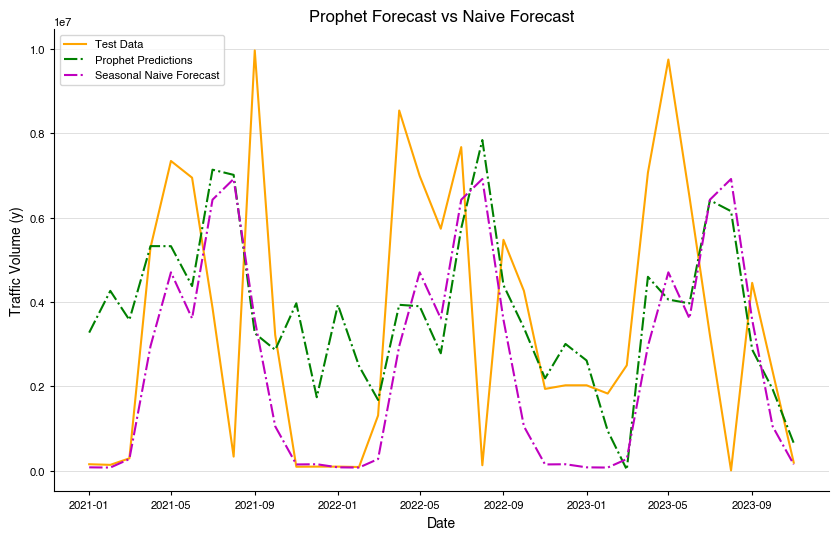

In [185]:
ptest_plot = ptest.copy()
ptest_plot['prophet_pred'] = prophet_pred

fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(ptrain['ds'], ptrain['y'], label='Train Data')
ax.plot(ptest['ds'], ptest['y'], label='Test Data', color='orange')
ax.plot(ptest_plot['ds'], ptest_plot['prophet_pred'], 'g-.', label='Prophet Predictions')
# ax.plot(ptest_plot['ds'], ptest_plot['mean_forecast'], 'c-.', label='Mean Forecast')
ax.plot(ptest_plot['ds'], ptest_plot['seasonal_naive_forecast'], 'm-.', label='Seasonal Naive Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Traffic Volume (y)')
ax.set_title('Prophet Forecast vs Naive Forecast')
plt.legend()
plt.show()

## XGBoost

In [150]:
xgbtrain = ptrain.copy()
xgbtest = ptest.copy()

In [151]:
print(xgbtrain.columns)
print(xgbtest.columns)

Index(['ds', 'y'], dtype='object')
Index(['ds', 'y', 'mean_forecast', 'naive_forecast',
       'seasonal_naive_forecast'],
      dtype='object')


In [152]:
xgbtrain.head()

,ds,y
0,2000-03-01,4079983.0
1,2000-04-01,11856901.0
2,2000-05-01,9222997.0
3,2000-06-01,8759275.0
4,2000-07-01,10122191.0


In [153]:
xgbtest.head()

,ds,y,mean_forecast,naive_forecast,seasonal_naive_forecast
250,2021-01-01,153264.0,7224024.432,153264.0,79608.0
251,2021-02-01,138432.0,7224024.432,153264.0,74472.0
252,2021-03-01,293061.0,7224024.432,153264.0,276847.0
253,2021-04-01,5293743.0,7224024.432,153264.0,2954148.0
254,2021-05-01,7347240.0,7224024.432,153264.0,4705494.0


In [154]:
def create_dt_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['ds'] = pd.to_datetime(df['ds'], errors='coerce')

    df['hour'] = df['ds'].dt.hour
    df['dayofweek'] = df['ds'].dt.dayofweek
    df['quarter'] = df['ds'].dt.quarter
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    df['dayofyear'] = df['ds'].dt.dayofyear
    df['dayofmonth'] = df['ds'].dt.day
    df['weekofyear'] = df['ds'].dt.isocalendar().week.astype("int64")

    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear']]
    
    if label:
        y = df[label]
        return X, y
    return X


In [155]:
X_train, y_train = create_dt_features(xgbtrain, label='y') 
X_test, y_test = create_dt_features(xgbtest, label='y')


In [156]:
X_train.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,0,2,1,3,2000,61,1,9
1,0,5,2,4,2000,92,1,13
2,0,0,2,5,2000,122,1,18
3,0,3,2,6,2000,153,1,22
4,0,5,3,7,2000,183,1,26


In [157]:
y_train.head()

0     4079983.0
1    11856901.0
2     9222997.0
3     8759275.0
4    10122191.0
Name: y, dtype: float64

In [158]:
import xgboost as xgb
print(xgb.__version__)

2.1.1


In [178]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Function to create lagged features for XGBoost
def create_lagged_features(df, lags=[1, 2, 3]):
    for lag in lags:
        df[f'y_lag_{lag}'] = df['y'].shift(lag)
    return df.dropna()

# Apply the function to create multiple lags for the training set
ptrain_lagged = create_lagged_features(ptrain, lags=[1, 2, 3])

# Use multiple lag features for training in XGBoost
X = ptrain_lagged[['y_lag_1', 'y_lag_2', 'y_lag_3']]
y = ptrain_lagged['y']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Set up XGBoost parameters
params = {
    'objective': 'reg:squarederror',  # For regression task
    'eval_metric': 'rmse',
    'max_depth': 5,
    'eta': 0.1
}
# Train the XGBoost model
watchlist = [(dtrain, 'train'), (dval, 'eval')]
bst = xgb.train(params, dtrain, num_boost_round=100, evals=watchlist, early_stopping_rounds=10)

# Create lagged features for the test set
ptest['y_lag_1'] = ptest['y'].shift(1)
ptest['y_lag_2'] = ptest['y'].shift(2)
ptest['y_lag_3'] = ptest['y'].shift(3)

# Drop NaN values that were introduced by the shift operation
ptest_lagged = ptest.dropna()

# Align the actual values after dropping NaN values
y_test_actual = ptest_lagged['y'].values

# Create a DMatrix for the test set using the lagged features
dtest = xgb.DMatrix(ptest_lagged[['y_lag_1', 'y_lag_2', 'y_lag_3']])

# Make predictions
xgb_pred = bst.predict(dtest)


[0]	train-rmse:3943544.20619	eval-rmse:5713719.31519
[1]	train-rmse:3688704.23003	eval-rmse:5446562.31483
[2]	train-rmse:3455540.07958	eval-rmse:5210381.66164
[3]	train-rmse:3248393.02254	eval-rmse:5048888.49593


[4]	train-rmse:3059342.33819	eval-rmse:4920114.87696
[5]	train-rmse:2888977.57316	eval-rmse:4818638.22776
[6]	train-rmse:2741897.22779	eval-rmse:4745316.15078
[7]	train-rmse:2589952.45782	eval-rmse:4654015.06233
[8]	train-rmse:2461343.31722	eval-rmse:4566157.31886
[9]	train-rmse:2343045.86188	eval-rmse:4498332.78168
[10]	train-rmse:2238272.65700	eval-rmse:4431622.85184
[11]	train-rmse:2143963.73854	eval-rmse:4388887.51855
[12]	train-rmse:2048447.56294	eval-rmse:4328612.82246
[13]	train-rmse:1971855.73826	eval-rmse:4284029.89133
[14]	train-rmse:1905108.04725	eval-rmse:4248571.44490
[15]	train-rmse:1836928.99775	eval-rmse:4198601.46078
[16]	train-rmse:1782875.18898	eval-rmse:4161142.49739
[17]	train-rmse:1726579.33155	eval-rmse:4126746.62329
[18]	train-rmse:1677358.12936	eval-rmse:4128094.35606
[19]	train-rmse:1637369.11832	eval-rmse:4121597.55130
[20]	train-rmse:1600085.35942	eval-rmse:4104660.29539
[21]	train-rmse:1558915.86950	eval-rmse:4090551.36183
[22]	train-rmse:1524168.39554	eval

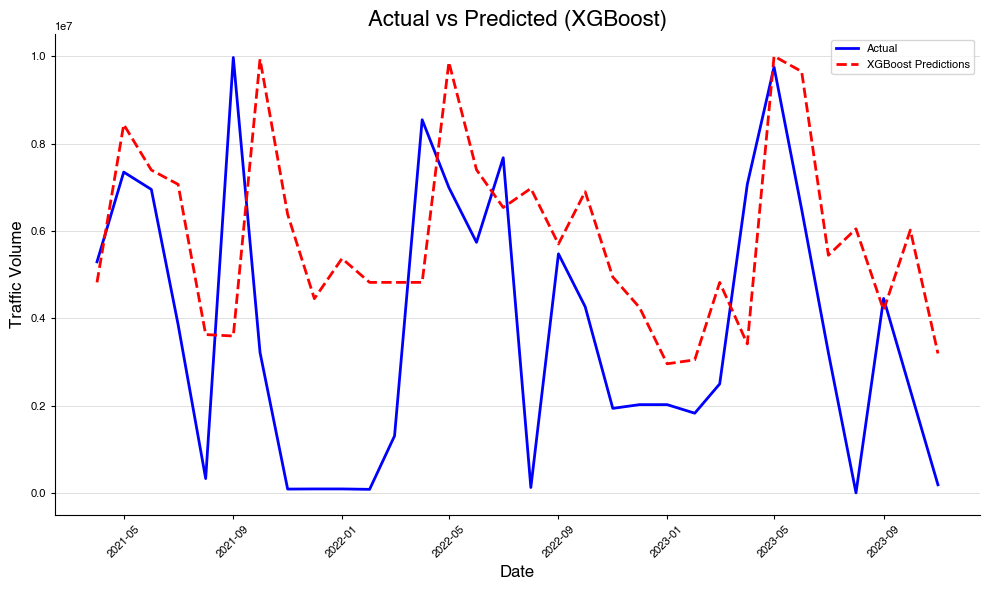

In [184]:

# Plot actual vs predicted (XGBoost)
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(ptest_lagged['ds'], y_test_actual, label="Actual", color='blue', linewidth=2)

# Plot XGBoost predictions
plt.plot(ptest_lagged['ds'], xgb_pred, label="XGBoost Predictions", color='red', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted (XGBoost)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Traffic Volume', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [177]:
# Function to calculate SMAPE
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

# Calculate SMAPE for XGBoost
smape_xgb = smape(y_test_actual, xgb_pred)
print(f'SMAPE (XGBoost): {smape_xgb:.2f}%')

SMAPE (XGBoost): 82.93%


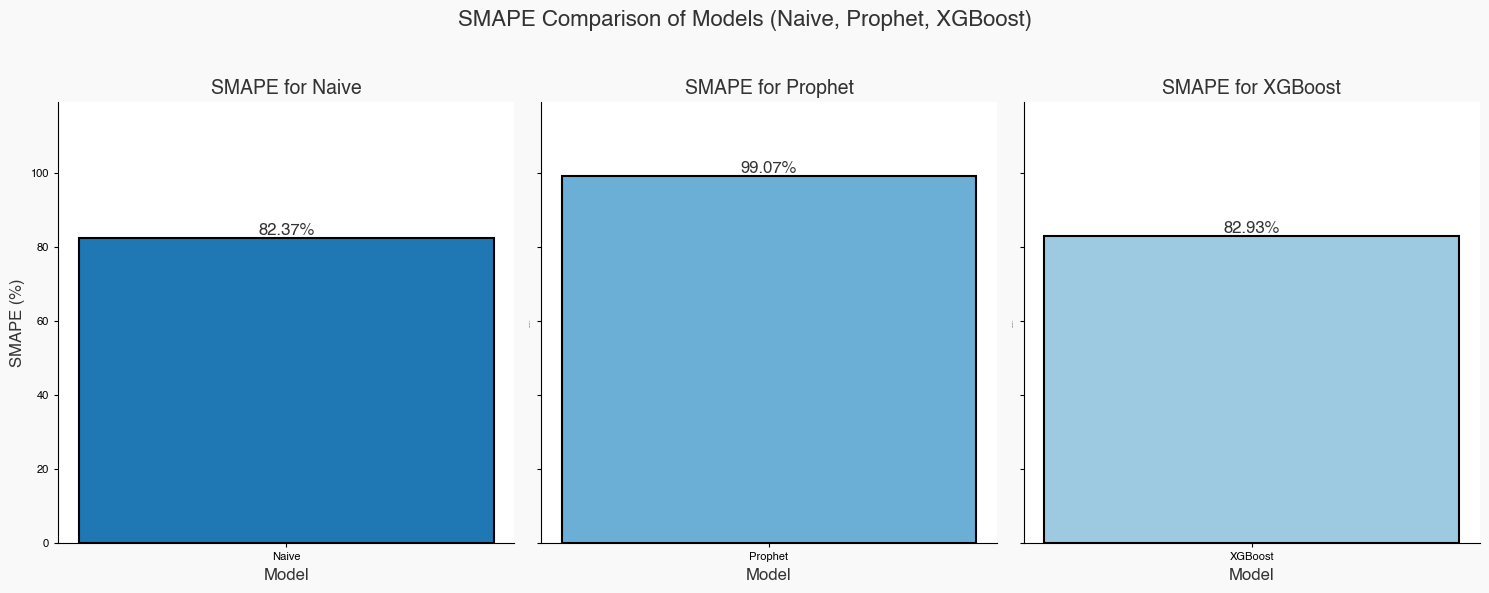

In [196]:

# SMAPE values for each model
smape_naive = 82.37
smape_prophet = 99.07
smape_xgb = 82.93

# Create a list of models SMAPE values
models = ['Naive', 'Prophet', 'XGBoost']
smape_values = [smape_naive, smape_prophet, smape_xgb]

# Different shades of blue for each model
colors = ['#1f77b4', '#6baed6', '#9ecae1']  # Palette of blues
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True, facecolor='#f9f9f9')

# Loop through each model to create a bar plot in a separate subplot
for i, ax in enumerate(axes):
    ax.bar(models[i], smape_values[i], color=colors[i], edgecolor='black', linewidth=1.5)
    ax.set_title(f'SMAPE for {models[i]}', fontsize=14, color='#333333')
    ax.set_ylabel('SMAPE (%)', fontsize=12 if i == 0 else 0, color='#333333') 
    ax.set_ylim(0, max(smape_values) + 20)
    ax.set_xlabel('Model', fontsize=12, color='#333333')
    ax.grid(False)
    ax.text(0, smape_values[i] + 1, f'{smape_values[i]:.2f}%', ha='center', fontsize=12, color='#333333')

plt.suptitle('SMAPE Comparison of Models (Naive, Prophet, XGBoost)', fontsize=16, color='#333333')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
